In [ ]:
#data preprocessing and model training
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data = pd.read_csv("yield_df.csv")
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)


for col in data.select_dtypes(include=['number']).columns:
    data[col] = data[col].fillna(data[col].mean())


categorical_cols = ['Area', 'Item']
numeric_cols = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'hg/ha_yield']
target_col = 'hg/ha_yield'


label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


joblib.dump(label_encoders, "label_encoders.pkl")


scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


joblib.dump(scaler, "scaler.pkl")


train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]


class CropYieldDataset(Dataset):
    def __init__(self, df):
        self.X = df.drop(columns=[target_col]).values.astype(np.float32)
        self.y = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])


train_loader = DataLoader(CropYieldDataset(train_data), batch_size=64, shuffle=True)
test_loader = DataLoader(CropYieldDataset(test_data), batch_size=64, shuffle=False)


class SmallTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.2),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        x = self.input_proj(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()


input_dim = len(categorical_cols) + len(numeric_cols) - 1
model = SmallTransformer(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


best_loss = float('inf')
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model.pth")


model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(outputs)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n--- Evaluation ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.1303
Epoch 2, Loss: 0.0293
Epoch 3, Loss: 0.0284
Epoch 4, Loss: 0.0279
Epoch 5, Loss: 0.0273
Epoch 6, Loss: 0.0260
Epoch 7, Loss: 0.0248
Epoch 8, Loss: 0.0216
Epoch 9, Loss: 0.0178
Epoch 10, Loss: 0.0159
Epoch 11, Loss: 0.0156
Epoch 12, Loss: 0.0146
Epoch 13, Loss: 0.0139
Epoch 14, Loss: 0.0135
Epoch 15, Loss: 0.0136
Epoch 16, Loss: 0.0139
Epoch 17, Loss: 0.0125
Epoch 18, Loss: 0.0124
Epoch 19, Loss: 0.0125
Epoch 20, Loss: 0.0124
Epoch 21, Loss: 0.0132
Epoch 22, Loss: 0.0118
Epoch 23, Loss: 0.0115
Epoch 24, Loss: 0.0113
Epoch 25, Loss: 0.0106
Epoch 26, Loss: 0.0121
Epoch 27, Loss: 0.0154
Epoch 28, Loss: 0.0113
Epoch 29, Loss: 0.0111
Epoch 30, Loss: 0.0112
Epoch 31, Loss: 0.0106
Epoch 32, Loss: 0.0105
Epoch 33, Loss: 0.0101
Epoch 34, Loss: 0.0098
Epoch 35, Loss: 0.0091
Epoch 36, Loss: 0.0092
Epoch 37, Loss: 0.0085
Epoch 38, Loss: 0.0088
Epoch 39, Loss: 0.0079
Epoch 40, Loss: 0.0068
Epoch 41, Loss: 0.0074
Epoch 42, Loss: 0.0063
Epoch 43, Loss: 0.0066
Epoch 44, Loss: 0.00

<ipython-input-14-ee1d3f01d09c>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



--- Evaluation ---
MAE: 0.0608
RMSE: 0.0952
R² Score: 0.7168



--- Transformer Model Evaluation on Test Dataset ---
MAE                : 0.0344
MSE                : 0.0043
RMSE               : 0.0655
R² Score           : 0.8515
F1 Score           : 0.9012
Accuracy           : 90.47%


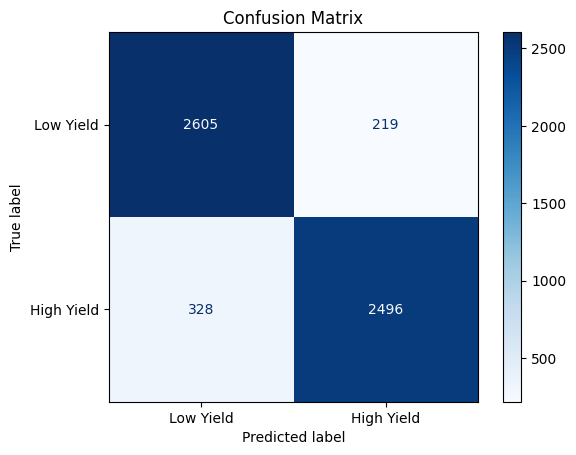

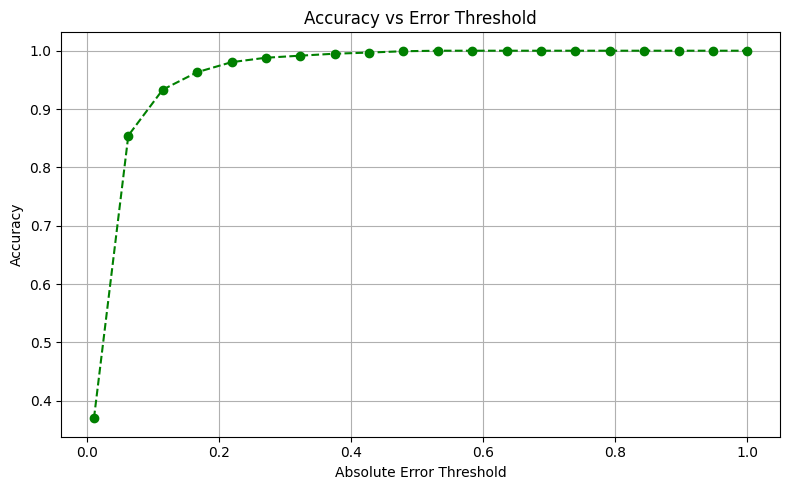

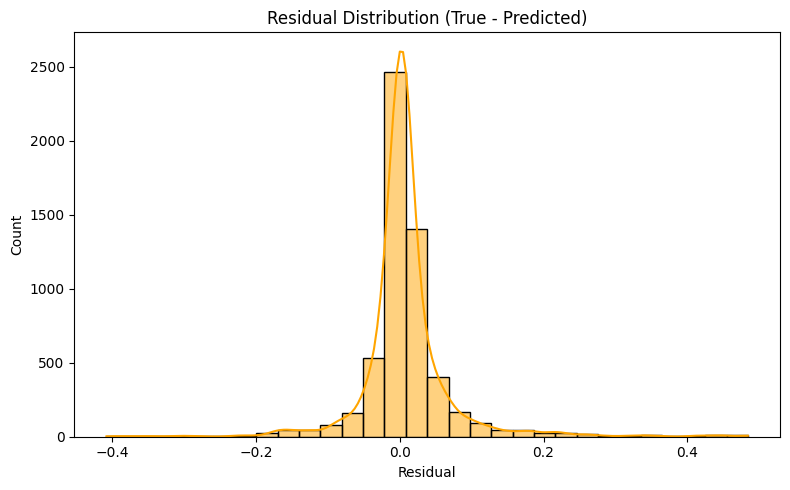

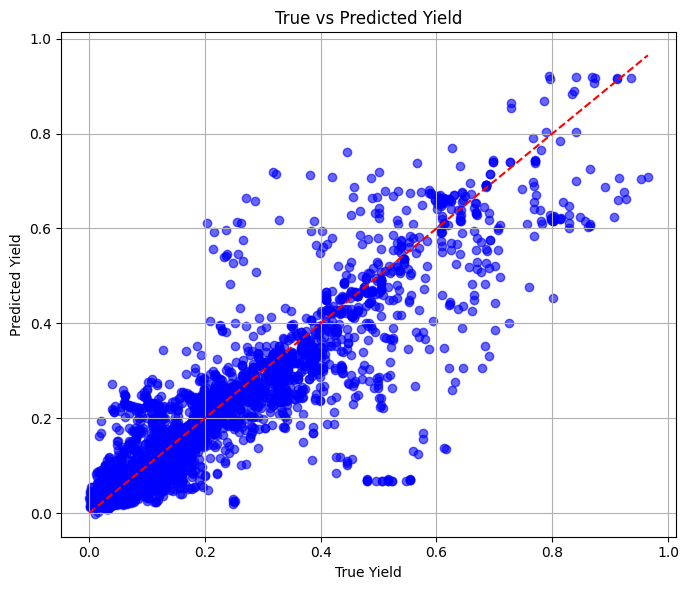

In [ ]:
#model evaluation and visualization
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerIMSTModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=2048):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.2),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        x = self.input_proj(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()


test_data_path = '/content/drive/MyDrive/IMST2/test_dataset.csv'
model_path = '/content/drive/MyDrive/IMST2/best_model.pth'
scaler_path = '/content/drive/MyDrive/IMST2/scaler (1).pkl'
encoders_path = '/content/drive/MyDrive/IMST2/label_encoders (1).pkl'

target_col = 'hg/ha_yield'
categorical_cols = ['Area', 'Item']
numerical_cols = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
all_features = categorical_cols + numerical_cols

df = pd.read_csv(test_data_path)
label_encoders = joblib.load(encoders_path)
scaler = joblib.load(scaler_path)

for col in categorical_cols:
    df[col] = label_encoders[col].transform(df[col])

scaled = scaler.transform(df[numerical_cols + [target_col]])
df[numerical_cols + [target_col]] = scaled

X_test = df[all_features].values.astype(np.float32)
y_test = df[target_col].values.astype(np.float32)

X_test_tensor = torch.tensor(X_test).to(device)
y_test_tensor = torch.tensor(y_test).to(device)

model = TransformerIMSTModel(input_dim=X_test.shape[1]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


with torch.no_grad():
    y_pred_tensor = model(X_test_tensor).squeeze()
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
median_yield = np.median(y_true)
f1 = f1_score((y_true > median_yield).astype(int), (y_pred > median_yield).astype(int), zero_division=1)
accuracy = np.mean(np.abs(y_pred - y_true) / y_true <= 0.8)

print("\n--- Transformer Model Evaluation on Test Dataset ---")
print(f"MAE                : {mae:.4f}")
print(f"MSE                : {mse:.4f}")
print(f"RMSE               : {rmse:.4f}")
print(f"R² Score           : {r2:.4f}")
print(f"F1 Score           : {f1:.4f}")
print(f"Accuracy           : {accuracy * 100:.2f}%")



true_binary = (y_true > median_yield).astype(int)
pred_binary = (y_pred > median_yield).astype(int)

cm = confusion_matrix(true_binary, pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Yield", "High Yield"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

thresholds = np.linspace(0.01, 1.0, 20)
accuracies = [np.mean(np.abs(y_pred - y_true) <= t) for t in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker='o', linestyle='--', color='green')
plt.xlabel("Absolute Error Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Error Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()


residuals = y_true - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color="orange")
plt.title("Residual Distribution (True - Predicted)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, alpha=0.6, color="blue")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("True Yield")
plt.ylabel("Predicted Yield")
plt.title("True vs Predicted Yield")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#user input and prediction
import torch
import joblib
import numpy as np
import pandas as pd
from torch import nn


label_encoders = joblib.load("/content/drive/MyDrive/IMST2/label_encoders (1).pkl")
scaler = joblib.load("/content/drive/MyDrive/IMST2/scaler (1).pkl")

area_classes = label_encoders["Area"].classes_
item_classes = label_encoders["Item"].classes_


class SmallTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.2),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        x = self.input_proj(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()


input_dim = 6
model = SmallTransformer(input_dim=input_dim)
model.load_state_dict(torch.load("/content/drive/MyDrive/IMST2/best_model.pth", map_location='cpu'))
model.eval()


def case_insensitive_match(user_input, classes):
    matches = [cls for cls in classes if user_input.lower() in cls.lower()]
    if not matches:
        raise ValueError(f"Invalid input '{user_input}'. Options: {classes}")
    return matches[0]


print(f"Available Areas: {list(area_classes)}")
print(f"Available Items: {list(item_classes)}")

user_area = input("Enter Area: ").strip()
user_item = input("Enter Item: ").strip()

matched_area = case_insensitive_match(user_area, area_classes)
matched_item = case_insensitive_match(user_item, item_classes)


area_encoded = label_encoders["Area"].transform([matched_area])[0]
item_encoded = label_encoders["Item"].transform([matched_item])[0]


year = float(input("Enter Year: "))
rainfall = float(input("Enter Average Rainfall (mm): "))
pesticides = float(input("Enter Pesticides Used (tonnes): "))
temp = float(input("Enter Average Temperature (°C): "))


columns = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'hg/ha_yield']
input_df = pd.DataFrame([[year, rainfall, pesticides, temp, 0.0]], columns=columns)
scaled = scaler.transform(input_df)[:, :-1]


features = np.concatenate([[area_encoded, item_encoded], scaled.flatten()]).astype(np.float32)
input_tensor = torch.tensor(features).unsqueeze(0)


with torch.no_grad():
    prediction_scaled = model(input_tensor).item()


input_with_prediction = np.append(scaled.flatten(), prediction_scaled).reshape(1, -1)
real_yield = scaler.inverse_transform(input_with_prediction)[0, -1]

print(f"\n Predicted Crop Yield (hg/ha): {real_yield:.2f}")


Available Areas: ['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Central African Republic', 'Chile', 'Colombia', 'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Estonia', 'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Libya', 'Lithuania', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Norway', 'Pakistan', 'Papua New Guinea', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Slovenia', '